In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

# 假设有一些预定义的常量
# sku_info
NUM_ITEM_FIRST_CATE = 2 + 1
NUM_ITEM_SECOND_CATE = 7 + 1
NUM_ITEM_THIRD_CATE = 44 + 1
NUM_BRAND = 126 + 1
# sku_prom
NUM_PROMOTION_TYPE = 7 + 1
# store_weather
NUM_WEATHER_TYPE = 303 + 1

# 输入层
input_item_first_cate = Input(shape=(1,), name='input_item_first_cate', dtype='int32')
input_item_second_cate = Input(shape=(1,), name='input_item_second_cate', dtype='int32')
input_item_third_cate = Input(shape=(1,), name='input_item_third_cate', dtype='int32')
input_brand = Input(shape=(1,), name='input_brand', dtype='int32')
input_promotion_type = Input(shape=(1,), name='input_promotion_type', dtype='int32')
input_weather_type = Input(shape=(1,), name='input_weather_type', dtype='int32')

# 嵌入层
item_first_cate_embedding = Embedding(input_dim=NUM_ITEM_FIRST_CATE, output_dim=8, input_length=1,
                                      name='item_first_cate_embedding')(input_item_first_cate)
item_second_cate_embedding = Embedding(input_dim=NUM_ITEM_SECOND_CATE, output_dim=8, input_length=1,
                                       name='item_second_cate_embedding')(input_item_second_cate)
item_third_cate_embedding = Embedding(input_dim=NUM_ITEM_THIRD_CATE, output_dim=8, input_length=1,
                                        name='item_third_cate_embedding')(input_item_third_cate)
brand_embedding = Embedding(input_dim=NUM_BRAND, output_dim=8, input_length=1,
                            name='brand_embedding')(input_brand)
promotion_type_embedding = Embedding(input_dim=NUM_PROMOTION_TYPE, output_dim=8, input_length=1,
                                     name='promotion_type_embedding')(input_promotion_type)
weather_type_embedding = Embedding(input_dim=NUM_WEATHER_TYPE, output_dim=8, input_length=1,
                                      name='weather_type_embedding')(input_weather_type)

# 将嵌入向量平展化以便输入到密集层
item_first_cate_vecs = Flatten()(item_first_cate_embedding)
item_second_cate_vecs = Flatten()(item_second_cate_embedding)
item_third_cate_vecs = Flatten()(item_third_cate_embedding)
brand_vecs = Flatten()(brand_embedding)
promotion_type_vecs = Flatten()(promotion_type_embedding)
weather_type_vecs = Flatten()(weather_type_embedding)

# 合并操作
concat = Concatenate()([item_first_cate_vecs, item_second_cate_vecs, item_third_cate_vecs,
                        brand_vecs, promotion_type_vecs, weather_type_vecs])

# 添加密集层进行预测
dense_1 = Dense(64, activation='relu')(concat)
dense_2 = Dense(32, activation='relu')(dense_1)
predictions = Dense(1)(dense_2)

# 定义模型
model = Model(inputs=[input_item_first_cate, input_item_second_cate, input_item_third_cate,
                      input_brand, input_promotion_type, input_weather_type],
              outputs=predictions)

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')  # 对于回归问题，一个常见的损失函数是均方误差

# 查看模型结构
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_item_first_cate (Inp  [(None, 1)]                  0         []                            
 utLayer)                                                                                         
                                                                                                  
 input_item_second_cate (In  [(None, 1)]                  0         []                            
 putLayer)                                                                                        
                                                                                                  
 input_item_third_cate (Inp  [(None, 1)]                  0         []                            
 utLayer)                                                                                     

In [238]:
# 固定随机数种子
tf.random.set_seed(23)

In [8]:
import pandas as pd

data_sku_info = pd.read_csv('data/sku_info.csv')
data_sku_prom = pd.read_csv('data/sku_prom.csv')
data_store_weather = pd.read_csv('data/store_weather.csv')
data_sku_sales = pd.read_csv('data/sku_sales.csv')

In [9]:
data_sku_sales['date'] = pd.to_datetime(data_sku_sales['order_time'])
data_sku_sales['date'] = data_sku_sales['date'].dt.date
data_sku_prom['date'] = pd.to_datetime(data_sku_prom['date'])
data_sku_prom['date'] = data_sku_prom['date'].dt.date
data_store_weather['date'] = pd.to_datetime(data_store_weather['date'])
data_store_weather['date'] = data_store_weather['date'].dt.date

In [11]:
data_sku_sales = data_sku_sales.groupby(['store_id', 'sku_id', 'date', 'channel']).count().reset_index()
data_sku_sales = data_sku_sales[['store_id', 'sku_id', 'date', 'channel', 'order_id']].reset_index()
data_sku_sales.rename(columns={'order_id': 'count'}, inplace=True)
data_sku_sales.drop("index", axis=1, inplace=True)
data_sku_sales

,store_id,sku_id,date,channel,count
0,1,1,2022-05-23,2,1
1,1,1,2022-05-28,2,3
2,1,1,2022-05-29,2,2
3,1,1,2022-05-30,2,1
4,1,1,2022-05-31,2,1
...,...,...,...,...,...
4130680,12,1000,2023-08-27,2,1
4130681,12,1000,2023-08-28,2,1
4130682,12,1000,2023-08-29,2,2
4130683,12,1000,2023-08-31,1,1


In [12]:
data_sku_prom = data_sku_prom[['store_id', 'sku_id', 'date', 'promotion_type']]
data_sku_prom

,store_id,sku_id,date,promotion_type
0,6,1,2022-05-27,1
1,6,1,2022-05-27,1
2,6,1,2022-05-28,1
3,6,1,2022-05-28,1
4,6,1,2022-05-29,1
...,...,...,...,...
2271884,12,851,2023-07-20,7
2271885,5,851,2023-07-17,7
2271886,5,851,2023-07-18,7
2271887,5,851,2023-07-19,7


In [13]:
data_store_weather = data_store_weather[['store_id', 'date', 'weather_type']]
data_store_weather

,store_id,date,weather_type
0,3,2022-01-30,14
1,3,2022-04-13,1
2,3,2022-07-17,0
3,3,2022-08-23,7
4,3,2022-12-17,1
...,...,...,...
8142,12,2023-04-06,0
8143,12,2022-10-10,0
8144,12,2023-01-20,0
8145,12,2023-04-12,0


In [20]:
# 将四张表合并，使用inner join
data = pd.merge(data_sku_sales, data_sku_info, on=['sku_id'], how='inner')
data = pd.merge(data, data_sku_prom, on=['store_id', 'sku_id', 'date'], how='inner')
data = pd.merge(data, data_store_weather, on=['store_id', 'date'], how='inner')
data

,store_id,sku_id,date,channel,count,item_first_cate_cd,item_second_cate_cd,item_third_cate_cd,brand_code,promotion_type,weather_type
0,1,1,2022-05-28,2,3,1,1,1,1,1,1
1,1,1,2022-05-28,2,3,1,1,1,1,1,1
2,1,7,2022-05-28,2,1,1,1,1,5,5,1
3,1,7,2022-05-28,2,1,1,1,1,5,5,1
4,1,12,2022-05-28,1,1,2,3,6,9,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2734673,4,455,2022-10-20,1,1,1,1,1,26,5,1
2734674,4,685,2022-10-17,1,1,1,2,5,47,5,0
2734675,4,685,2022-10-17,1,1,1,2,5,47,5,0
2734676,4,685,2022-10-19,1,3,1,2,5,47,5,1


In [21]:
# 去除store_id，sku_id，date，channel
data.drop(['store_id', 'sku_id', 'date', 'channel'], axis=1, inplace=True)
data

,count,item_first_cate_cd,item_second_cate_cd,item_third_cate_cd,brand_code,promotion_type,weather_type
0,3,1,1,1,1,1,1
1,3,1,1,1,1,1,1
2,1,1,1,1,5,5,1
3,1,1,1,1,5,5,1
4,1,2,3,6,9,1,1
...,...,...,...,...,...,...,...
2734673,1,1,1,1,26,5,1
2734674,1,1,2,5,47,5,0
2734675,1,1,2,5,47,5,0
2734676,3,1,2,5,47,5,1


In [22]:
# 将count进行归一化
data['count'] = data['count'] / data['count'].max()
data

,count,item_first_cate_cd,item_second_cate_cd,item_third_cate_cd,brand_code,promotion_type,weather_type
0,0.007160,1,1,1,1,1,1
1,0.007160,1,1,1,1,1,1
2,0.002387,1,1,1,5,5,1
3,0.002387,1,1,1,5,5,1
4,0.002387,2,3,6,9,1,1
...,...,...,...,...,...,...,...
2734673,0.002387,1,1,1,26,5,1
2734674,0.002387,1,2,5,47,5,0
2734675,0.002387,1,2,5,47,5,0
2734676,0.007160,1,2,5,47,5,1


In [23]:
# 将数据集划分为训练集和测试集
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=2020)
train.shape, test.shape

((2187742, 7), (546936, 7))

In [24]:
# 将训练集和测试集划分为特征和标签
train_label = train['count']
train_features = train.drop(['count'], axis=1)
test_label = test['count']
test_features = test.drop(['count'], axis=1)
train_label.shape, train_features.shape, test_label.shape, test_features.shape

((2187742,), (2187742, 6), (546936,), (546936, 6))

In [26]:
# 将训练集和测试集划分为多输入
train_features = [train_features['item_first_cate_cd'], train_features['item_second_cate_cd'],
                  train_features['item_third_cate_cd'], train_features['brand_code'],
                  train_features['promotion_type'], train_features['weather_type']]
test_features = [test_features['item_first_cate_cd'], test_features['item_second_cate_cd'],
                 test_features['item_third_cate_cd'], test_features['brand_code'],
                 test_features['promotion_type'], test_features['weather_type']]
train_label = train_label.values
test_label = test_label.values

In [27]:
# 训练模型
model.fit(train_features, train_label, epochs=2, batch_size=32, validation_data=(test_features, test_label))

Epoch 1/10
68367/68367 [==============================] - 116s 2ms/step - loss: 3.1389e-04 - val_loss: 3.1743e-04
Epoch 2/10
68367/68367 [==============================] - 124s 2ms/step - loss: 3.1117e-04 - val_loss: 3.1433e-04
Epoch 3/10
68367/68367 [==============================] - 136s 2ms/step - loss: 3.1092e-04 - val_loss: 3.1736e-04
Epoch 4/10
 1052/68367 [..............................] - ETA: 1:53 - loss: 3.0131e-04

KeyboardInterrupt: 

In [28]:
# 保存embedding层的权重
item_first_cate_embedding_weights = model.get_layer('item_first_cate_embedding').get_weights()[0]
item_second_cate_embedding_weights = model.get_layer('item_second_cate_embedding').get_weights()[0]
item_third_cate_embedding_weights = model.get_layer('item_third_cate_embedding').get_weights()[0]
brand_embedding_weights = model.get_layer('brand_embedding').get_weights()[0]
promotion_type_embedding_weights = model.get_layer('promotion_type_embedding').get_weights()[0]
weather_type_embedding_weights = model.get_layer('weather_type_embedding').get_weights()[0]

# 保存embedding层的权重
import pickle

with open('model/embedding/item_first_cate_embedding_weights.pkl', 'wb') as f:
    pickle.dump(item_first_cate_embedding_weights, f)
with open('model/embedding/item_second_cate_embedding_weights.pkl', 'wb') as f:
    pickle.dump(item_second_cate_embedding_weights, f)
with open('model/embedding/item_third_cate_embedding_weights.pkl', 'wb') as f:
    pickle.dump(item_third_cate_embedding_weights, f)
with open('model/embedding/brand_embedding_weights.pkl', 'wb') as f:
    pickle.dump(brand_embedding_weights, f)
with open('model/embedding/promotion_type_embedding_weights.pkl', 'wb') as f:
    pickle.dump(promotion_type_embedding_weights, f)
with open('model/embedding/weather_type_embedding_weights.pkl', 'wb') as f:
    pickle.dump(weather_type_embedding_weights, f)

In [ ]:
# 加载权重
import pickle

with open('model/embedding/item_first_cate_embedding_weights.pkl', 'rb') as f:
    item_first_cate_embedding_weights = pickle.load(f)
with open('model/embedding/item_second_cate_embedding_weights.pkl', 'rb') as f:
    item_second_cate_embedding_weights = pickle.load(f)
with open('model/embedding/item_third_cate_embedding_weights.pkl', 'rb') as f:
    item_third_cate_embedding_weights = pickle.load(f)
with open('model/embedding/brand_embedding_weights.pkl', 'rb') as f:
    brand_embedding_weights = pickle.load(f)
with open('model/embedding/promotion_type_embedding_weights.pkl', 'rb') as f:
    promotion_type_embedding_weights = pickle.load(f)
with open('model/embedding/weather_type_embedding_weights.pkl', 'rb') as f:
    weather_type_embedding_weights = pickle.load(f)

In [31]:
data_sku_sales

,store_id,sku_id,date,channel,count
0,1,1,2022-05-23,2,1
1,1,1,2022-05-28,2,3
2,1,1,2022-05-29,2,2
3,1,1,2022-05-30,2,1
4,1,1,2022-05-31,2,1
...,...,...,...,...,...
4130680,12,1000,2023-08-27,2,1
4130681,12,1000,2023-08-28,2,1
4130682,12,1000,2023-08-29,2,2
4130683,12,1000,2023-08-31,1,1


In [32]:
# 准备数据
import pandas as pd

data_sku_info = pd.read_csv('data/sku_info.csv')
data_sku_prom = pd.read_csv('data/sku_prom.csv')
data_store_weather = pd.read_csv('data/store_weather.csv')
data_sku_sales = pd.read_csv('data/sku_sales.csv')

data_sku_sales['date'] = pd.to_datetime(data_sku_sales['order_time'])
data_sku_sales['date'] = data_sku_sales['date'].dt.date
data_sku_prom['date'] = pd.to_datetime(data_sku_prom['date'])
data_sku_prom['date'] = data_sku_prom['date'].dt.date
data_store_weather['date'] = pd.to_datetime(data_store_weather['date'])
data_store_weather['date'] = data_store_weather['date'].dt.date

data_sku_sales = data_sku_sales.groupby(['store_id', 'sku_id', 'date', 'channel']).count().reset_index()
data_sku_sales = data_sku_sales[['store_id', 'sku_id', 'date', 'channel', 'order_id']].reset_index()
data_sku_sales.rename(columns={'order_id': 'count'}, inplace=True)
data_sku_sales.drop("index", axis=1, inplace=True)
data_sku_sales

,store_id,sku_id,date,channel,count
0,1,1,2022-05-23,2,1
1,1,1,2022-05-28,2,3
2,1,1,2022-05-29,2,2
3,1,1,2022-05-30,2,1
4,1,1,2022-05-31,2,1
...,...,...,...,...,...
4130680,12,1000,2023-08-27,2,1
4130681,12,1000,2023-08-28,2,1
4130682,12,1000,2023-08-29,2,2
4130683,12,1000,2023-08-31,1,1


In [44]:
data_prices = pd.read_csv('data/sku_price_and_status.csv')
data_prices['date'] = pd.to_datetime(data_prices['date'])
data_prices['date'] = data_prices['date'].dt.date
data_prices

,store_id,sku_id,date,salable_status,stock_status,original_price
0,6,1,2022-06-16,1,1,25.48
1,6,1,2023-04-08,1,1,25.48
2,6,1,2021-10-07,0,1,25.48
3,6,1,2021-12-25,0,1,25.48
4,6,1,2022-12-02,1,1,25.48
...,...,...,...,...,...,...
5104151,4,367,2023-08-17,1,1,17.28
5104152,4,367,2023-08-14,1,1,17.28
5104153,4,367,2023-08-15,1,1,17.28
5104154,4,367,2023-08-29,1,1,17.28


In [33]:
COUNT_MAX = data_sku_sales['count'].max()
COUNT_MAX

579

In [62]:
THRESHOLD_MAX = data_sku_prom['threshold'].max()
THRESHOLD_MAX

27.6

In [63]:
PRICE_MAX = data_prices['original_price'].max()
PRICE_MAX

111.68

In [289]:
TEST_STORE_ID = 4
TEST_SKU_ID = 1
TEST_CHANNEL = 1

data_sales_single = data_sku_sales[(data_sku_sales['store_id'] == TEST_STORE_ID) & (data_sku_sales['sku_id'] == TEST_SKU_ID) & (data_sku_sales['channel'] == TEST_CHANNEL)].copy()
data_info_single = data_sku_info[data_sku_info['sku_id'] == TEST_SKU_ID].copy()
data_prom_single = data_sku_prom[(data_sku_prom['store_id'] == TEST_STORE_ID) & (data_sku_prom['sku_id'] == TEST_SKU_ID) & (data_sku_prom['channel'] == TEST_CHANNEL)].copy()
data_weather_single = data_store_weather[data_store_weather['store_id'] == TEST_STORE_ID].copy()
data_prices_single = data_prices[(data_prices['store_id'] == TEST_STORE_ID) & (data_prices['sku_id'] == TEST_SKU_ID)].copy()

In [290]:
print("columns of data_sales_single: ", data_sales_single.columns)
print("columns of data_info_single: ", data_info_single.columns)
print("columns of data_prom_single: ", data_prom_single.columns)
print("columns of data_weather_single: ", data_weather_single.columns)
print("columns of data_prices_single: ", data_prices_single.columns)

columns of data_sales_single:  Index(['store_id', 'sku_id', 'date', 'channel', 'count'], dtype='object')
columns of data_info_single:  Index(['sku_id', 'item_first_cate_cd', 'item_second_cate_cd',
       'item_third_cate_cd', 'brand_code'],
      dtype='object')
columns of data_prom_single:  Index(['store_id', 'sku_id', 'date', 'promotion_id', 'curr_day', 'total_days',
       'promotion_type', 'threshold', 'discount_off', 'channel'],
      dtype='object')
columns of data_weather_single:  Index(['store_id', 'date', 'weather_type', 'min_temperature',
       'max_temperature'],
      dtype='object')
columns of data_prices_single:  Index(['store_id', 'sku_id', 'date', 'salable_status', 'stock_status',
       'original_price'],
      dtype='object')


In [291]:
# date的range为data_sales_single的date的最小值和最大值
date_min = data_sales_single['date'].min()
date_max = data_sales_single['date'].max()
date_range = pd.date_range(date_min, date_max)
date_range

DatetimeIndex(['2022-05-21', '2022-05-22', '2022-05-23', '2022-05-24',
               '2022-05-25', '2022-05-26', '2022-05-27', '2022-05-28',
               '2022-05-29', '2022-05-30',
               ...
               '2023-08-16', '2023-08-17', '2023-08-18', '2023-08-19',
               '2023-08-20', '2023-08-21', '2023-08-22', '2023-08-23',
               '2023-08-24', '2023-08-25'],
              dtype='datetime64[ns]', length=462, freq='D')

In [292]:
date_range_df = pd.DataFrame(date_range, columns=['date'])
date_range_df['date'] = date_range_df['date'].dt.date

In [293]:
# 处理data_sales_single
# 将date_range和data_sales_single进行merge，以便后续填充缺失值
data_sales_single = pd.merge(data_sales_single, date_range_df, on=['date'], how='right')
data_sales_single

,store_id,sku_id,date,channel,count
0,4.0,1.0,2022-05-21,1.0,1.0
1,NaN,NaN,2022-05-22,NaN,NaN
2,NaN,NaN,2022-05-23,NaN,NaN
3,NaN,NaN,2022-05-24,NaN,NaN
4,NaN,NaN,2022-05-25,NaN,NaN
...,...,...,...,...,...
457,4.0,1.0,2023-08-21,1.0,1.0
458,4.0,1.0,2023-08-22,1.0,1.0
459,NaN,NaN,2023-08-23,NaN,NaN
460,NaN,NaN,2023-08-24,NaN,NaN


In [294]:
# 对store_id, sku_id, channel进行填充
data_sales_single['store_id'].fillna(TEST_STORE_ID, inplace=True)
data_sales_single['sku_id'].fillna(TEST_SKU_ID, inplace=True)
data_sales_single['channel'].fillna(TEST_CHANNEL, inplace=True)
# data_sales_single['count'].fillna(0, inplace=True)

In [295]:
data_sales_single

,store_id,sku_id,date,channel,count
0,4.0,1.0,2022-05-21,1.0,1.0
1,4.0,1.0,2022-05-22,1.0,NaN
2,4.0,1.0,2022-05-23,1.0,NaN
3,4.0,1.0,2022-05-24,1.0,NaN
4,4.0,1.0,2022-05-25,1.0,NaN
...,...,...,...,...,...
457,4.0,1.0,2023-08-21,1.0,1.0
458,4.0,1.0,2023-08-22,1.0,1.0
459,4.0,1.0,2023-08-23,1.0,NaN
460,4.0,1.0,2023-08-24,1.0,NaN


In [296]:
# 处理data_price_single
data_prices_single = pd.merge(data_prices_single, date_range_df, on=['date'], how='right')
data_prices_single['store_id'].fillna(TEST_STORE_ID, inplace=True)
data_prices_single['sku_id'].fillna(TEST_SKU_ID, inplace=True)
data_prices_single['salable_status'].fillna(0, inplace=True)
data_prices_single['stock_status'].fillna(0, inplace=True)
data_prices_single['original_price'].fillna(method='ffill', inplace=True)
data_prices_single

C:\Users\Yipeng\AppData\Local\Temp\ipykernel_15456\823654211.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_prices_single['original_price'].fillna(method='ffill', inplace=True)


,store_id,sku_id,date,salable_status,stock_status,original_price
0,4,1,2022-05-21,0,1,0.228152
1,4,1,2022-05-22,0,1,0.228152
2,4,1,2022-05-23,0,1,0.228152
3,4,1,2022-05-24,0,1,0.228152
4,4,1,2022-05-25,0,1,0.228152
...,...,...,...,...,...,...
457,4,1,2023-08-21,1,1,0.200394
458,4,1,2023-08-22,1,1,0.200394
459,4,1,2023-08-23,1,1,0.200394
460,4,1,2023-08-24,1,1,0.200394


In [297]:
data_prices_single['original_price'] = data_prices_single['original_price'] / PRICE_MAX
data_prices_single

,store_id,sku_id,date,salable_status,stock_status,original_price
0,4,1,2022-05-21,0,1,0.002043
1,4,1,2022-05-22,0,1,0.002043
2,4,1,2022-05-23,0,1,0.002043
3,4,1,2022-05-24,0,1,0.002043
4,4,1,2022-05-25,0,1,0.002043
...,...,...,...,...,...,...
457,4,1,2023-08-21,1,1,0.001794
458,4,1,2023-08-22,1,1,0.001794
459,4,1,2023-08-23,1,1,0.001794
460,4,1,2023-08-24,1,1,0.001794


In [298]:
# 对sku_prom进行处理
data_prom_single['curr_day'] = data_prom_single['curr_day'] / data_prom_single['total_days']
data_prom_single.drop(['total_days'], axis=1, inplace=True)
data_prom_single['threshold'] = data_prom_single['threshold'] / THRESHOLD_MAX
data_prom_single.drop(['promotion_id'], axis=1, inplace=True)
# 先保存每个日期下最大的discount_off的那一行
data_prom_single = data_prom_single.groupby(['date']).max().reset_index()
data_prom_single = pd.merge(data_prom_single, date_range_df, on=['date'], how='right')
data_prom_single

,date,store_id,sku_id,curr_day,promotion_type,threshold,discount_off,channel
0,2022-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
457,2023-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,2023-08-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
459,2023-08-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
460,2023-08-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [299]:
# 填充缺失值
data_prom_single['store_id'].fillna(TEST_STORE_ID, inplace=True)
data_prom_single['sku_id'].fillna(TEST_SKU_ID, inplace=True)
data_prom_single['channel'].fillna(TEST_CHANNEL, inplace=True)
data_prom_single.fillna(0, inplace=True)
data_prom_single

,date,store_id,sku_id,curr_day,promotion_type,threshold,discount_off,channel
0,2022-05-21,4.0,1.0,0.000000,0.0,0.00000,0.0,1.0
1,2022-05-22,4.0,1.0,0.000000,0.0,0.00000,0.0,1.0
2,2022-05-23,4.0,1.0,0.000000,0.0,0.00000,0.0,1.0
3,2022-05-24,4.0,1.0,0.000000,0.0,0.00000,0.0,1.0
4,2022-05-25,4.0,1.0,0.000000,0.0,0.00000,0.0,1.0
...,...,...,...,...,...,...,...,...
457,2023-08-21,4.0,1.0,0.000000,0.0,0.00000,0.0,1.0
458,2023-08-22,4.0,1.0,0.000000,0.0,0.00000,0.0,1.0
459,2023-08-23,4.0,1.0,0.000000,0.0,0.00000,0.0,1.0
460,2023-08-24,4.0,1.0,0.000000,0.0,0.00000,0.0,1.0


In [300]:
# 合并data_sales_single, data_info_single, data_prom_single, data_weather_single, data_prices_single
data_single = pd.merge(data_sales_single, data_info_single, on=['sku_id'], how='left')
data_single = pd.merge(data_single, data_prom_single, on=['store_id', 'sku_id', 'date', 'channel'], how='left')
data_single = pd.merge(data_single, data_weather_single, on=['store_id', 'date'], how='left')
data_single = pd.merge(data_single, data_prices_single, on=['store_id', 'sku_id', 'date'], how='left')
data_single

,store_id,sku_id,date,channel,count,item_first_cate_cd,item_second_cate_cd,item_third_cate_cd,brand_code,curr_day,promotion_type,threshold,discount_off,weather_type,min_temperature,max_temperature,salable_status,stock_status,original_price
0,4.0,1.0,2022-05-21,1.0,1.0,1,1,1,1,0.000000,0.0,0.00000,0.0,0,0.62,0.89,0,1,0.002043
1,4.0,1.0,2022-05-22,1.0,NaN,1,1,1,1,0.000000,0.0,0.00000,0.0,0,0.62,0.87,0,1,0.002043
2,4.0,1.0,2022-05-23,1.0,NaN,1,1,1,1,0.000000,0.0,0.00000,0.0,1,0.62,0.85,0,1,0.002043
3,4.0,1.0,2022-05-24,1.0,NaN,1,1,1,1,0.000000,0.0,0.00000,0.0,4,0.60,0.84,0,1,0.002043
4,4.0,1.0,2022-05-25,1.0,NaN,1,1,1,1,0.000000,0.0,0.00000,0.0,0,0.55,0.78,0,1,0.002043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,4.0,1.0,2023-08-21,1.0,1.0,1,1,1,1,0.000000,0.0,0.00000,0.0,0,0.65,0.78,1,1,0.001794
458,4.0,1.0,2023-08-22,1.0,1.0,1,1,1,1,0.000000,0.0,0.00000,0.0,0,0.62,0.84,1,1,0.001794
459,4.0,1.0,2023-08-23,1.0,NaN,1,1,1,1,0.000000,0.0,0.00000,0.0,4,0.64,0.84,1,1,0.001794
460,4.0,1.0,2023-08-24,1.0,NaN,1,1,1,1,0.000000,0.0,0.00000,0.0,1,0.60,0.67,1,1,0.001794


In [301]:
# 对于salable_status为1的count缺失值置为0
data_single.loc[(data_single['salable_status'] == 1) & (data_single['count'].isnull()), 'count'] = 0
data_single

,store_id,sku_id,date,channel,count,item_first_cate_cd,item_second_cate_cd,item_third_cate_cd,brand_code,curr_day,promotion_type,threshold,discount_off,weather_type,min_temperature,max_temperature,salable_status,stock_status,original_price
0,4.0,1.0,2022-05-21,1.0,1.0,1,1,1,1,0.000000,0.0,0.00000,0.0,0,0.62,0.89,0,1,0.002043
1,4.0,1.0,2022-05-22,1.0,NaN,1,1,1,1,0.000000,0.0,0.00000,0.0,0,0.62,0.87,0,1,0.002043
2,4.0,1.0,2022-05-23,1.0,NaN,1,1,1,1,0.000000,0.0,0.00000,0.0,1,0.62,0.85,0,1,0.002043
3,4.0,1.0,2022-05-24,1.0,NaN,1,1,1,1,0.000000,0.0,0.00000,0.0,4,0.60,0.84,0,1,0.002043
4,4.0,1.0,2022-05-25,1.0,NaN,1,1,1,1,0.000000,0.0,0.00000,0.0,0,0.55,0.78,0,1,0.002043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,4.0,1.0,2023-08-21,1.0,1.0,1,1,1,1,0.000000,0.0,0.00000,0.0,0,0.65,0.78,1,1,0.001794
458,4.0,1.0,2023-08-22,1.0,1.0,1,1,1,1,0.000000,0.0,0.00000,0.0,0,0.62,0.84,1,1,0.001794
459,4.0,1.0,2023-08-23,1.0,0.0,1,1,1,1,0.000000,0.0,0.00000,0.0,4,0.64,0.84,1,1,0.001794
460,4.0,1.0,2023-08-24,1.0,0.0,1,1,1,1,0.000000,0.0,0.00000,0.0,1,0.60,0.67,1,1,0.001794


In [302]:
data_single['count'].fillna(method='ffill', inplace=True)
data_single.isnull().sum()

C:\Users\Yipeng\AppData\Local\Temp\ipykernel_15456\53084615.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_single['count'].fillna(method='ffill', inplace=True)


store_id               0
sku_id                 0
date                   0
channel                0
count                  0
item_first_cate_cd     0
item_second_cate_cd    0
item_third_cate_cd     0
brand_code             0
curr_day               0
promotion_type         0
threshold              0
discount_off           0
weather_type           0
min_temperature        0
max_temperature        0
salable_status         0
stock_status           0
original_price         0
dtype: int64

In [303]:
# 划分数据集，date到2023-08-17的数据为训练集，2023-08-18到2023-08-31的数据为测试集
train_single = data_single[data_single['date'] <= pd.to_datetime('2023-08-17').date()].copy()
test_single = data_single[data_single['date'] > pd.to_datetime('2023-08-17').date()].copy()
train_single.shape, test_single.shape

((454, 19), (8, 19))

In [304]:
train_single.drop(['store_id', 'sku_id', 'date', 'channel'], axis=1, inplace=True)
test_single.drop(['store_id', 'sku_id', 'date', 'channel'], axis=1, inplace=True)
train_single.shape, test_single.shape

((454, 15), (8, 15))

In [305]:
# 将训练集和测试集划分为特征和标签
train_label = train_single['count']
train_features = train_single.drop(['count'], axis=1)
test_label = test_single['count']
test_features = test_single.drop(['count'], axis=1)
train_label.shape, train_features.shape, test_label.shape, test_features.shape

((454,), (454, 14), (8,), (8, 14))

In [306]:
# 将训练集和测试集划分为多输入
train_features = [train_features['item_first_cate_cd'], train_features['item_second_cate_cd'],
                  train_features['item_third_cate_cd'], train_features['brand_code'],
                  train_features['promotion_type'], train_features['weather_type'],
                  train_features.drop(['item_first_cate_cd', 'item_second_cate_cd', 'item_third_cate_cd',
                                       'brand_code', 'promotion_type', 'weather_type'], axis=1)]
test_features = [test_features['item_first_cate_cd'], test_features['item_second_cate_cd'],
                    test_features['item_third_cate_cd'], test_features['brand_code'],
                    test_features['promotion_type'], test_features['weather_type'],
                    test_features.drop(['item_first_cate_cd', 'item_second_cate_cd', 'item_third_cate_cd',
                                        'brand_code', 'promotion_type', 'weather_type'], axis=1)]
train_label = train_label.values
test_label = test_label.values

In [307]:
for i in train_features:
    print(i.shape)

(454,)
(454,)
(454,)
(454,)
(454,)
(454,)
(454, 8)


In [308]:
# 对label进行一下归一化
train_label = train_label / COUNT_MAX

In [309]:
from tensorflow.keras import layers

HIDDEN_UNITS = 64

# 建立模型
class MQRNNModel(Model):
    def __init__(self):
        super(MQRNNModel, self).__init__()
        self.rnn = layers.LSTM(HIDDEN_UNITS, return_sequences=True)  # 可以选择GRU或其他RNN层
        self.fc = layers.TimeDistributed(layers.Dense(1))  # 针对序列的每个时间点预测
        # 嵌入层
        self.item_first_cate_embedding = Embedding(input_dim=NUM_ITEM_FIRST_CATE, output_dim=8, input_length=1,
                                            name='item_first_cate_embedding', trainable=False, weights=[item_first_cate_embedding_weights])
        self.item_second_cate_embedding = Embedding(input_dim=NUM_ITEM_SECOND_CATE, output_dim=8, input_length=1,
                                            name='item_second_cate_embedding', trainable=False, weights=[item_second_cate_embedding_weights])
        self.item_third_cate_embedding = Embedding(input_dim=NUM_ITEM_THIRD_CATE, output_dim=8, input_length=1,
                                            name='item_third_cate_embedding', trainable=False, weights=[item_third_cate_embedding_weights])
        self.brand_embedding = Embedding(input_dim=NUM_BRAND, output_dim=8, input_length=1,
                                            name='brand_embedding', trainable=False, weights=[brand_embedding_weights])
        self.promotion_type_embedding = Embedding(input_dim=NUM_PROMOTION_TYPE, output_dim=8, input_length=1,
                                            name='promotion_type_embedding', trainable=False, weights=[promotion_type_embedding_weights])
        self.weather_type_embedding = Embedding(input_dim=NUM_WEATHER_TYPE, output_dim=8, input_length=1,
                                            name='weather_type_embedding', trainable=False, weights=[weather_type_embedding_weights])

    def call(self, inputs):
        [i_item_first_cate,
         i_item_second_cate,
         i_item_third_cate,
         i_brand,
         i_promotion_type,
         i_weather_type,
         i_other_features] = inputs
        
        i_item_first_cate = self.item_first_cate_embedding(i_item_first_cate)
        i_item_second_cate = self.item_second_cate_embedding(i_item_second_cate)
        i_item_third_cate = self.item_third_cate_embedding(i_item_third_cate)
        i_brand = self.brand_embedding(i_brand)
        i_promotion_type = self.promotion_type_embedding(i_promotion_type)
        i_weather_type = self.weather_type_embedding(i_weather_type)
        i_other_features = tf.reshape(i_other_features, [-1, 1, 8])
        x = tf.concat([i_item_first_cate, i_item_second_cate, i_item_third_cate,
                            i_brand, i_promotion_type, i_weather_type, i_other_features], axis=-1)
        x = self.rnn(x)
        x = self.fc(x)
        return x

model = MQRNNModel()
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
# model.summary()

In [310]:
# 训练模型
model.fit(train_features, train_label, epochs=20, batch_size=32)

Epoch 1/20


15/15 [==============================] - 2s 4ms/step - loss: 0.0058
Epoch 2/20
15/15 [==============================] - 0s 2ms/step - loss: 9.9420e-04
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 4.0351e-04
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0655e-04
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 6.1667e-05
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 3.7595e-05
Epoch 7/20
15/15 [==============================] - 0s 4ms/step - loss: 2.7435e-05
Epoch 8/20
15/15 [==============================] - 0s 3ms/step - loss: 2.1139e-05
Epoch 9/20
15/15 [==============================] - 0s 2ms/step - loss: 1.7176e-05
Epoch 10/20
15/15 [==============================] - 0s 3ms/step - loss: 1.4148e-05
Epoch 11/20
15/15 [==============================] - 0s 3ms/step - loss: 1.2137e-05
Epoch 12/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0536e-05
Epoch 13/20
15/1

In [311]:
# 使用模型预测count，并与真实值进行比较
pred = model.predict(test_features)
pred = pred.reshape(-1, 1)
pred = pred * COUNT_MAX
pred = pred.astype(int)
pred

1/1 [==============================] - 0s 317ms/step


array([[1],
       [1],
       [0],
       [2],
       [1],
       [0],
       [2],
       [3]])

In [312]:
test_label = test_label.reshape(-1, 1)
test_label

array([[0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [3.]])

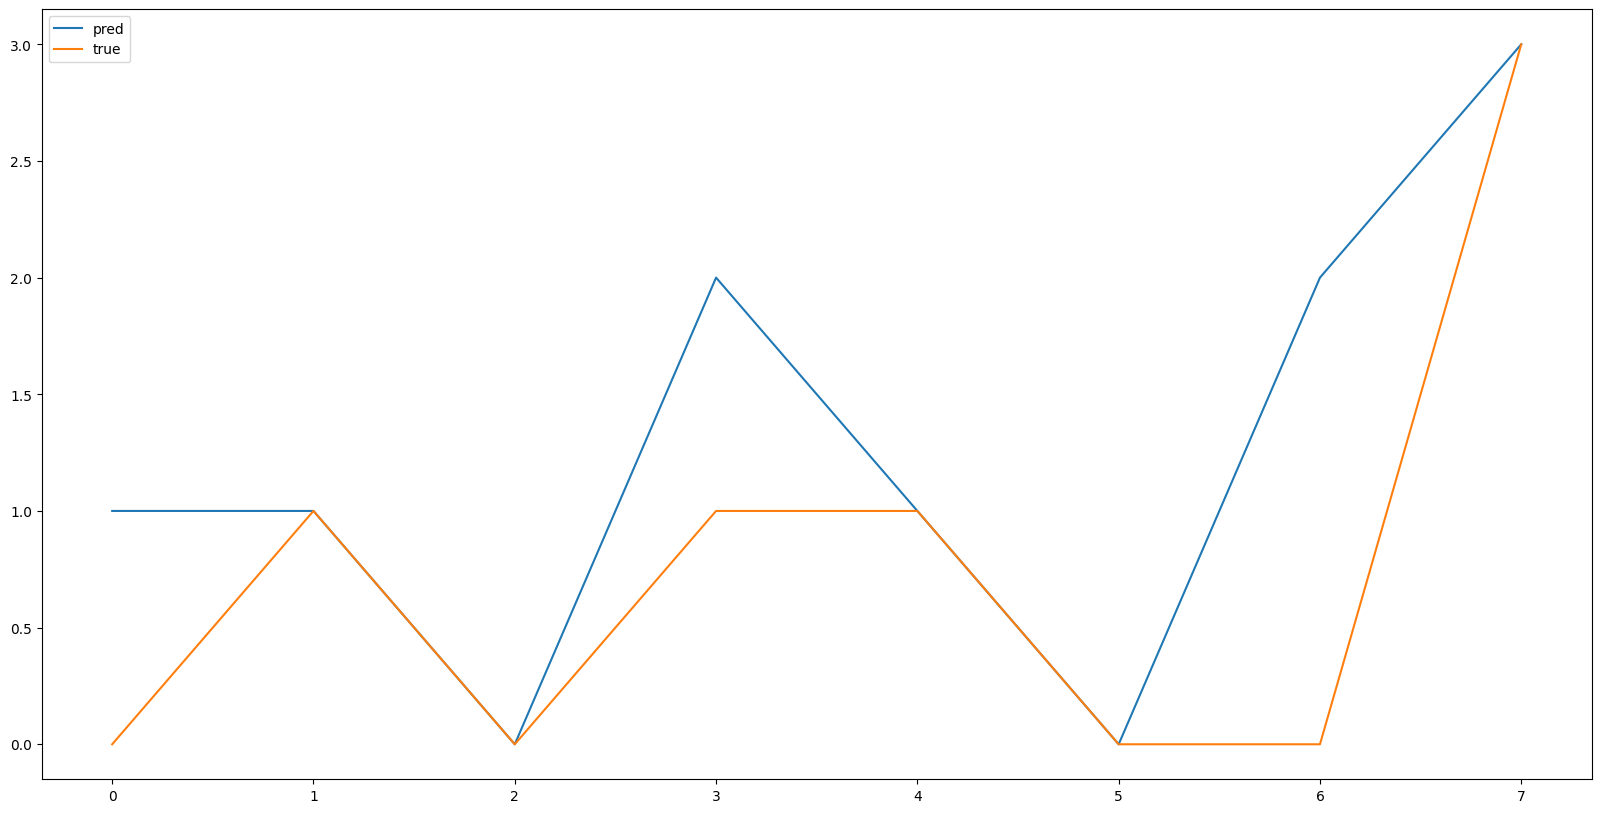

In [313]:
# 画图
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(pred, label='pred')
plt.plot(test_label, label='true')
plt.legend()
plt.show()

In [315]:
# 保存权重
model.save_weights(f'model/{TEST_STORE_ID}_{TEST_SKU_ID}_{TEST_CHANNEL}_mqrnn_weights.tf')

# 加载权重（您需要先实例化模型架构）
# model = MQRNNModel()  # 或您用于创建模型的任何代码
# model.load_weights(f'model/{TEST_STORE_ID}_{TEST_SKU_ID}_{TEST_CHANNEL}_mqrnn_weights.tf')